In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
import os  #iterate through directories or join paths
import cv2
from google.colab.patches import cv2_imshow
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D, Concatenate, Attention
from keras.layers import BatchNormalization
from keras.models import Model
from keras import Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzipping the dataset

# !unzip '/content/drive/MyDrive/EE769 Machine Learning/Project/archive.zip' -d '/content/drive/MyDrive/EE769 Machine Learning/Project/'

In [ ]:
# directory = "/content/drive/MyDrive/EE769/Big_Cats/train"
directory = "/content/drive/MyDrive/EE769 Machine Learning/Project/train"
categories = ["CARACAL","CHEETAH","LIONS","PUMA","TIGER"]

In [ ]:
# create the training dataset
train = []

def create_training_dataset():
  for category in categories:
    i = 0
    path = os.path.join(directory,category) 
    class_index = categories.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      img_size = 224
      img_array = cv2.resize(img_array, (img_size,img_size))
      train.append([img_array,class_index])
      i += 1
    print(f'Category: {category} images: {i}')

create_training_dataset()

Category: CARACAL images: 236
Category: CHEETAH images: 235
Category: LIONS images: 228
Category: PUMA images: 236
Category: TIGER images: 237


In [ ]:
#shuffle the data
random.seed(5)
random.shuffle(train)

In [ ]:
#splitting the data into training and validation dataset
train, val = train_test_split(train, test_size=0.12, random_state=42)

In [ ]:
X_train = []
y_train = []
img_size = 224

for image,label in train:
  X_train.append(image)
  y_train.append(label)
X_train = np.array(X_train).reshape(-1, img_size, img_size, 3) # -1 implies any number of images
y_train = np.array(y_train)
print(X_train.shape)
#normalize the data
X_train = X_train/255.0

(1031, 224, 224, 3)


In [ ]:
X_val = []
y_val = []
img_size = 224
for image,label in val:
  X_val.append(image)
  y_val.append(label)
X_val = np.array(X_val).reshape(-1, img_size, img_size, 3) # -1 implies any number of images
y_val = np.array(y_val)
print(X_val.shape)
X_val = X_val/255.0

(141, 224, 224, 3)


In [ ]:

# create the testing dataset
# merging the test and validate data into test data

directory1 = "/content/drive/MyDrive/EE769 Machine Learning/Project/test"
directory2 = "/content/drive/MyDrive/EE769 Machine Learning/Project/valid"

test = []

def create_testing_dataset():
  for category in categories:
    i = 0
    path = os.path.join(directory1,category) 
    class_index = categories.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      img_size = 224
      img_array = cv2.resize(img_array, (img_size,img_size))
      test.append([img_array,class_index])
      i += 1
  for category in categories:
    i = 0
    path = os.path.join(directory2,category) 
    class_index = categories.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      img_size = 224
      img_array = cv2.resize(img_array, (img_size,img_size))
      test.append([img_array,class_index])
      i += 1

create_testing_dataset()

In [ ]:
X_test = []
y_test = []
img_size = 224
for image,label in test:
  X_test.append(image)
  y_test.append(label)
X_test = np.array(X_test).reshape(-1, img_size, img_size, 3) # -1 implies any number of images
y_test = np.array(y_test)
print(X_test.shape)
X_test = X_test/255.0

(50, 224, 224, 3)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1031, 224, 224, 3)
(50, 224, 224, 3)
(141, 224, 224, 3)


In [ ]:
# convert to one hot encoing
num_classes = len(categories)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

In [ ]:
print(y_train[-10:])

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [ ]:
# Number of filters in Squeeze block = s1x1
# 1x1 convolution
# ReLU activation
def Squeeze(X, s1x1):
  momentum = 0.9
  X = Conv2D(s1x1, 1, activation = "relu")(X)
  X = BatchNormalization(momentum = momentum)(X)
  print(f'X.shape: {X.shape}')
  print("Squeeze done")
  return X  

In [ ]:
# Number 1x1 convolution of filters in Expand block = # Number 3x3 convolution of filters in Expand block = e
# e1x1 = e3x3 because they are concatenated further 
# ReLU activation
# Zero padding
def Expand(X, e):
  momentum = 0.9
  X1 = Conv2D(e, 1, activation = "relu")(X)
  X1 = BatchNormalization(momentum = momentum)(X1)
  print(f'X.shape: {X.shape}')
  X3 = Conv2D(e, 3, padding = "same",  activation = "relu")(X)  #padding = "same" for zero padding
  X3 = BatchNormalization(momentum = momentum)(X3)
  print(f'X.shape: {X.shape}')
  X = Concatenate(axis = -1)([X1,X3])                           #concatenating the third dimension
  print(f'X.shape: {X.shape}')
  print("Expand done")
  return X


In [ ]:
def Fire(X, s1x1, e):
  print(f's1x1: {s1x1}')
  print(f'e: {e}')
  X = Squeeze(X, s1x1)
  X = Expand(X, e)
  if (s1x1 < (2*e)):
    print("Fire module done")
    print("=============================================")
  else:
    print("Warning: s1x1 is >= (e1x1 + e3x3)")
  return X

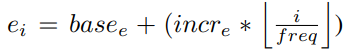

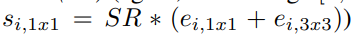

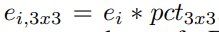

In [ ]:
def s1x1_(layer_num, base, incr, freq, SR):
  return (base + incr*(layer_num//freq))*SR

In [ ]:
def e_(layer_num, base, incr, freq, pct3x3):
  return (base + incr*(layer_num//freq))*pct3x3

In [ ]:
def SqueezeNet(num_rows, num_cols, num_channels, num_classes):
  num_filters = 48
  momentum = 0.9
  num_fire_pool = 3
  base = 32
  incr = 32
  freq = 2
  SR = 0.5
  pct3x3 = 0.5
  inp = Input (shape = (num_rows, num_cols, num_channels))    #224x224x3 
  print(f'inp.shape: {inp.shape}')
  X = Conv2D(num_filters , 7, strides = 2, padding = "same", activation = "relu")(inp)    
  X = BatchNormalization(momentum=momentum)(X)
  print(f'X.shape: {X.shape}')      
  for i in range(num_fire_pool):          
    X = MaxPooling2D(pool_size = (3, 3), strides = 2)(X)
    print(f'X.shape: {X.shape}')
    print("MaxPooling done")
    print("=============================================")
    X = Fire(X, s1x1_(2*i, base, incr, freq, SR), e_(2*i, base, incr, freq, pct3x3))
    X = Fire(X, s1x1_(2*i+1, base, incr, freq, SR), e_(2*i+1, base, incr, freq, pct3x3))
  # X = Fire(X, s1x1_(4, base, incr, freq, SR), e_(4, base, incr, freq, pct3x3))
  X = Dropout(0.2)(X)
  X = Conv2D(num_classes, 1, padding = "same")(X)                
  X = GlobalAveragePooling2D()(X)
  output = Activation("softmax")(X)

  model = Model(inputs = inp, outputs = output)

  opt = keras.optimizers.SGD(learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate = 0.04, decay_steps = 1000, end_learning_rate=0.0001, power=1.0))
  model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

  return model

In [ ]:
model = SqueezeNet(224, 224, 3, num_classes= len(categories))

inp.shape: (None, 224, 224, 3)
X.shape: (None, 112, 112, 48)
X.shape: (None, 55, 55, 48)
MaxPooling done
s1x1: 16.0
e: 16.0
X.shape: (None, 55, 55, 16)
Squeeze done
X.shape: (None, 55, 55, 16)
X.shape: (None, 55, 55, 16)
X.shape: (None, 55, 55, 32)
Expand done
Fire module done
s1x1: 16.0
e: 16.0
X.shape: (None, 55, 55, 16)
Squeeze done
X.shape: (None, 55, 55, 16)
X.shape: (None, 55, 55, 16)
X.shape: (None, 55, 55, 32)
Expand done
Fire module done
X.shape: (None, 27, 27, 32)
MaxPooling done
s1x1: 32.0
e: 32.0
X.shape: (None, 27, 27, 32)
Squeeze done
X.shape: (None, 27, 27, 32)
X.shape: (None, 27, 27, 32)
X.shape: (None, 27, 27, 64)
Expand done
Fire module done
s1x1: 32.0
e: 32.0
X.shape: (None, 27, 27, 32)
Squeeze done
X.shape: (None, 27, 27, 32)
X.shape: (None, 27, 27, 32)
X.shape: (None, 27, 27, 64)
Expand done
Fire module done
X.shape: (None, 13, 13, 64)
MaxPooling done
s1x1: 48.0
e: 48.0
X.shape: (None, 13, 13, 48)
Squeeze done
X.shape: (None, 13, 13, 48)
X.shape: (None, 13, 13, 48)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 75, validation_data=(X_val, y_val))

Epoch 1/75
33/33 [==============================] - 20s 105ms/step - loss: 1.4041 - accuracy: 0.3666 - val_loss: 2.4120 - val_accuracy: 0.1631
Epoch 2/75
33/33 [==============================] - 2s 48ms/step - loss: 1.1825 - accuracy: 0.4966 - val_loss: 2.8280 - val_accuracy: 0.2270
Epoch 3/75
33/33 [==============================] - 2s 48ms/step - loss: 1.0966 - accuracy: 0.5335 - val_loss: 2.4377 - val_accuracy: 0.1560
Epoch 4/75
33/33 [==============================] - 2s 48ms/step - loss: 0.9632 - accuracy: 0.5994 - val_loss: 1.2277 - val_accuracy: 0.4539
Epoch 5/75
33/33 [==============================] - 2s 48ms/step - loss: 0.9249 - accuracy: 0.6033 - val_loss: 1.2458 - val_accuracy: 0.4468
Epoch 6/75
33/33 [==============================] - 2s 48ms/step - loss: 0.8590 - accuracy: 0.6469 - val_loss: 11.6290 - val_accuracy: 0.2128
Epoch 7/75
33/33 [==============================] - 2s 55ms/step - loss: 0.8329 - accuracy: 0.6702 - val_loss: 1.5708 - val_accuracy: 0.4752
Epoch 8/75

In [ ]:
model.evaluate(X_test, y_test, batch_size = 32)

2/2 [==============================] - 0s 419ms/step - loss: 0.5242 - accuracy: 0.8000


[0.5242326259613037, 0.800000011920929]

In [ ]:
model.evaluate(X_train, y_train, batch_size = 32)

33/33 [==============================] - 1s 25ms/step - loss: 0.1225 - accuracy: 0.9855


[0.12246875464916229, 0.9854510426521301]

In [ ]:
model.evaluate(X_val, y_val, batch_size = 32)

5/5 [==============================] - 0s 15ms/step - loss: 0.6358 - accuracy: 0.7801


[0.6357517838478088, 0.7801418304443359]

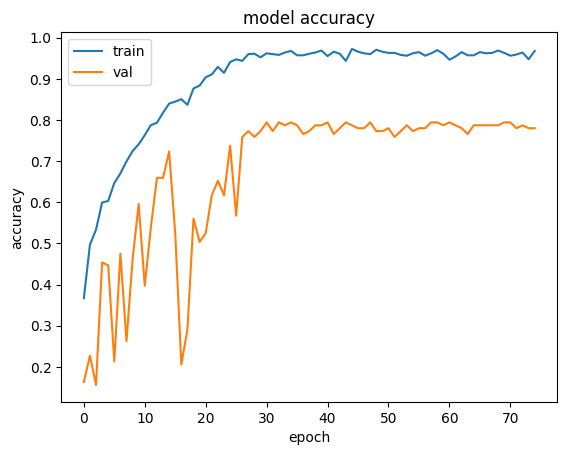

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 14ms/step


In [ ]:
y_pred = np.where(y_pred == np.amax(y_pred, axis = 1, keepdims=True), 1, 0)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.91      1.00      0.95        10
           2       0.75      0.60      0.67        10
           3       0.57      0.80      0.67        10
           4       1.00      0.80      0.89        10

   micro avg       0.80      0.80      0.80        50
   macro avg       0.82      0.80      0.80        50
weighted avg       0.82      0.80      0.80        50
 samples avg       0.80      0.80      0.80        50

